In [1]:
import numpy as np 
import time as tm 
import datetime as dt 
import tensorflow as tf 
import  yfinance as yf 
from sklearn.preprocessing import MinMaxScaler 
from collections import deque 

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,LSTM,Dropout 

import matplotlib.pyplot as plt 

设置我们的神经网络 我们将设置一些设置。我将简要解释每个选项：

N_STEPS 是我们窗口中的天数，即我们的神经网络将达到的深度。
'LOOKUP_STEPS' 数组包含我们将预测的天数。例如，我们有三天 [一天 — 明天，两天 — 后天，三天 — 后天两天]。对于 4 天或 5 天的预测，请添加相应的数字 [1， 2， 3， 4， 5]。
我们将在研究中检查名为 'STOCK' 的市场代码。谷歌（纳斯达克的 GOOGL）就是一个例子。
“date_now”让我们看到现在的股价，“date_3_years_back”让我们看到 1104 天前的股价。

In [2]:
N_STEPS = 7 
LOOKUP_STEPS = [1,2,3] 
STOCk = 'GOOGL' 

date_now = tm.strftime('%Y-%m-%d') 
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [5]:
init_df = yf.download(STOCk,start=date_3_years_back,end=date_now,interval='1d')

[*********************100%***********************]  1 of 1 completed


In [10]:
print(init_df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [11]:
# remove columns which our neural network will not use
init_df = init_df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'],axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

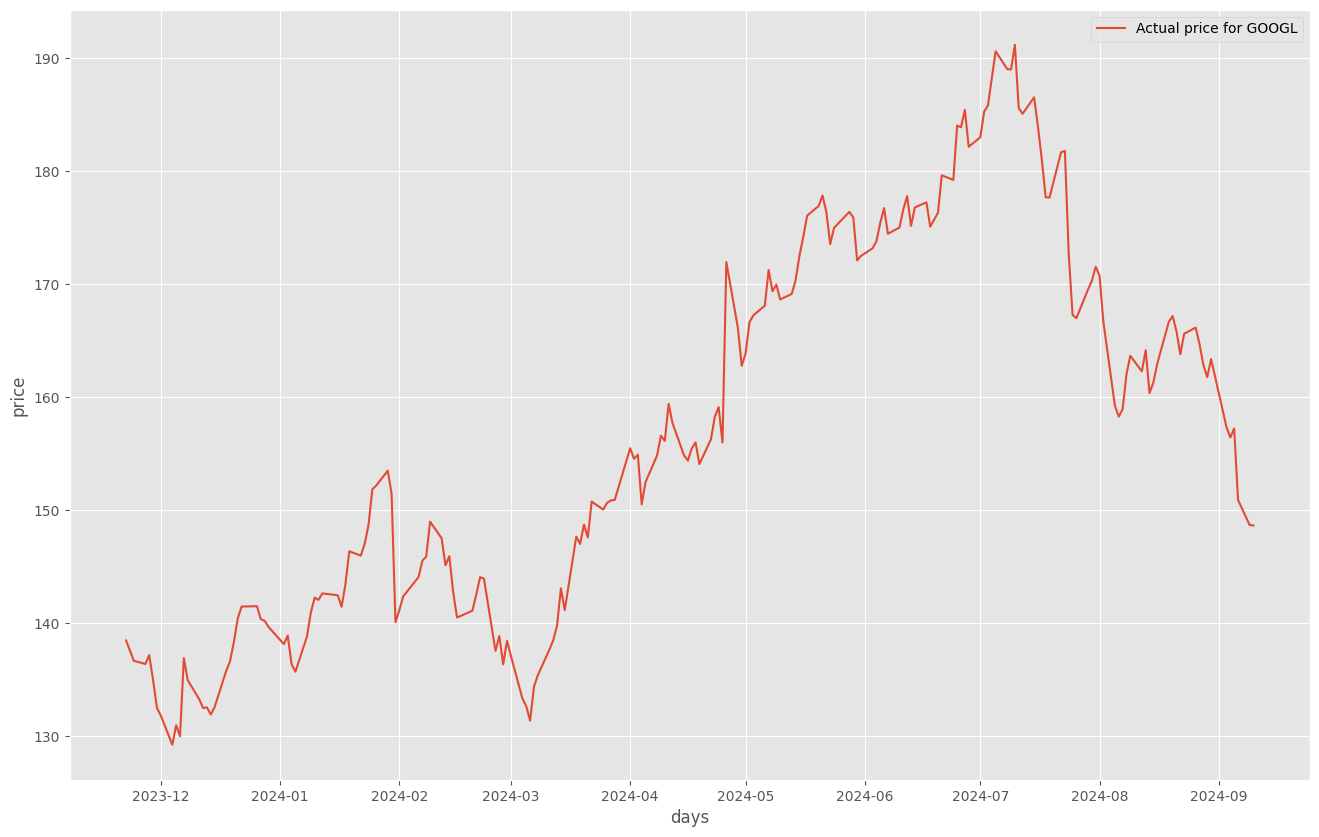

In [15]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['Close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCk}'])
plt.show()

In [17]:
scaler = MinMaxScaler()
init_df['Close'] = scaler.fit_transform(np.expand_dims(init_df['Close'].values,axis=1))

In [19]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['Close'].shift(-days)
  last_sequence = np.array(df[['Close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['Close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['Close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [20]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [21]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80


c:\Users\石天辰\.conda\envs\pytorch\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0351
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 16/80
94/94 ━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Epoch 1/80


c:\Users\石天辰\.conda\envs\pytorch\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0343
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 16/80
94/94 ━━━━━━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
Epoch 1/80


c:\Users\石天辰\.conda\envs\pytorch\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0363
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038 
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0042
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0032
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0036
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0030
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0030
Epoch 16/80
94/94 ━━━━━━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


In [22]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ValueError: cannot set a row with mismatched columns